In [3]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression


#TRAINING DATA----------------------------------------------------------------------------------
df=pd.read_csv('training.csv')

#get rid of commas/punctuation
punctuation_signs = list("?:!.,;")
df['article_words_parse_1'] = df['article_words']

for punct_sign in punctuation_signs:
    df['article_words_parse_1'] = df['article_words_parse_1'].str.replace(punct_sign, ' ')
    
#all lower case
df['article_words_parse_2'] = df['article_words_parse_1'].str.lower()

#NO STEMMING NO LEMMISATION, NO STOP WORDS

#Category Numbers
category_codes = {
    'ARTS CULTURE ENTERTAINMENT': 0,
    'BIOGRAPHIES PERSONALITIES PEOPLE': 1,
    'DEFENCE': 2,
    'DOMESTIC MARKETS': 3,
    'FOREX MARKETS': 4,
    'HEALTH': 5,
    'IRRELEVANT': 6,
    'MONEY MARKETS': 7,
    'SCIENCE AND TECHNOLOGY': 8,
    'SHARE LISTINGS': 9,
    'SPORTS': 10
}

# Category mapping
df['Category_Code'] = df['topic']
df = df.replace({'Category_Code':category_codes})

X_train=df['article_words_parse_2']
y_train=df['Category_Code']

#TESTING DATA--------------------------------------------------------------------------------
df_t=pd.read_csv('test.csv')

#get rid of commas/punctuation
punctuation_signs = list("?:!.,;")
df_t['article_words_parse_1'] = df_t['article_words']

for punct_sign in punctuation_signs:
    df_t['article_words_parse_1'] = df_t['article_words_parse_1'].str.replace(punct_sign, ' ')
    
#all lower case
df_t['article_words_parse_2'] = df_t['article_words_parse_1'].str.lower()

#NO STEMMING NO LEMMISATION, NO STOP WORDS

#Category Numbers
category_codes = {
    'ARTS CULTURE ENTERTAINMENT': 0,
    'BIOGRAPHIES PERSONALITIES PEOPLE': 1,
    'DEFENCE': 2,
    'DOMESTIC MARKETS': 3,
    'FOREX MARKETS': 4,
    'HEALTH': 5,
    'IRRELEVANT': 6,
    'MONEY MARKETS': 7,
    'SCIENCE AND TECHNOLOGY': 8,
    'SHARE LISTINGS': 9,
    'SPORTS': 10
}

# Category mapping
df_t['Category_Code'] = df_t['topic']
df_t = df_t.replace({'Category_Code':category_codes})

X_test=df_t['article_words_parse_2']
y_test=df_t['Category_Code']

#count how many of each topic
print("Samples per class (training): {}".format(np.bincount(y_train)))
print("Samples per class (testing): {}".format(np.bincount(y_test)))

print("Number of documents in train data: {}".format(len(X_train)))
print("Number of documents in test data: {}".format(len(X_test)))

Samples per class (training): [ 117  167  258  133  845  183 4734 1673   70  218 1102]
Samples per class (testing): [  3  15  13   2  48  14 266  69   3   7  60]
Number of documents in train data: 9500
Number of documents in test data: 500


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 4000

tfidf = TfidfVectorizer(encoding='utf-8',
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test)
labels_test = y_test
print(features_test.shape)

(9500, 4000)
(500, 4000)


In [7]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['saga']
class_weight = [None]
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   35.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_st...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
            

In [8]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1.0, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}

The mean accuracy of a model with these hyperparameters is:
0.759170653907496


In [9]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=8, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
best_lrc.fit(features_train, labels_train)

lrc_pred = best_lrc.predict(features_test)
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

The training accuracy is: 
0.8483157894736842
The test accuracy is: 
0.768
Classification report
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       1.00      0.13      0.24        15
           2       1.00      0.31      0.47        13
           3       0.00      0.00      0.00         2
           4       0.56      0.38      0.45        48
           5       0.86      0.43      0.57        14
           6       0.82      0.93      0.87       266
           7       0.55      0.67      0.60        69
           8       0.00      0.00      0.00         3
           9       0.50      0.29      0.36         7
          10       0.95      0.97      0.96        60

    accuracy                           0.77       500
   macro avg       0.60      0.40      0.44       500
weighted avg       0.77      0.77      0.75       500



C:\Users\Stephen Sung\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


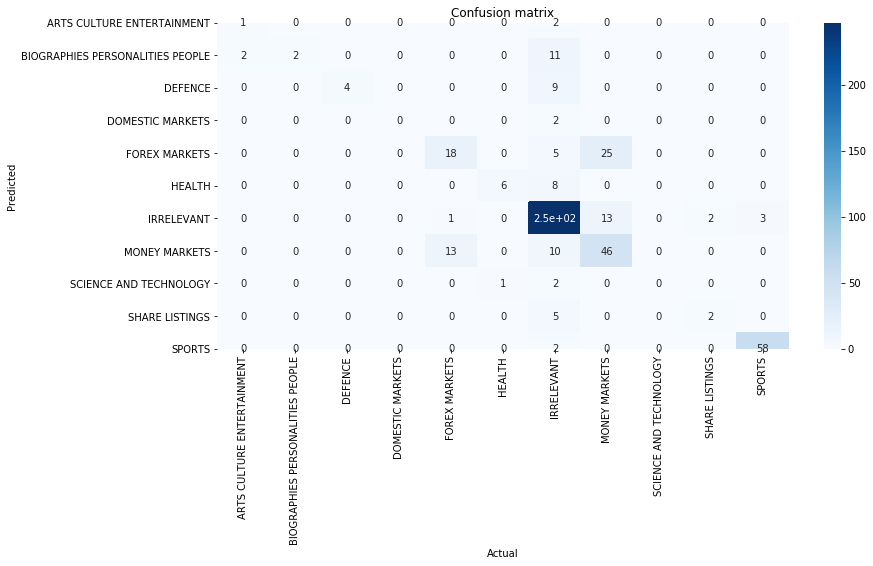

In [13]:
aux_df = df[['topic', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()